In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.nn.functional import one_hot

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (self.fc3(F.relu(self.fc2(F.relu(self.fc1(torch.flatten(x,1)))))))
        return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
import time

start = time.time()

results = []

for epoch in range(15):  # loop over the dataset multiple times
    count=0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        count=i
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # print statistics

    print(f'[{epoch + 1}, {count + 1:5d}] loss: {running_loss  :.10f}')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')   
    
    
    end = time.time()
    print(end - start)
    results += [[epoch,end-start,running_loss,100*correct/total]]
    running_loss = 0.0
print('Finished Training')

end = time.time()
print(end - start)

[1,  1563] loss: 2264.9010536671
Accuracy of the network on the 10000 test images: 56.58 %
17.694400310516357
[2,  1563] loss: 1686.0599543452
Accuracy of the network on the 10000 test images: 64.6 %
34.73084473609924
[3,  1563] loss: 1432.6766439080
Accuracy of the network on the 10000 test images: 67.18 %
51.573981523513794
[4,  1563] loss: 1267.3596669436
Accuracy of the network on the 10000 test images: 69.16 %
68.2143805027008
[5,  1563] loss: 1143.5895748734
Accuracy of the network on the 10000 test images: 69.52 %
84.72723889350891
[6,  1563] loss: 1047.1010627747
Accuracy of the network on the 10000 test images: 70.11 %
101.85073256492615
[7,  1563] loss: 959.5274345875
Accuracy of the network on the 10000 test images: 69.47 %
118.62958574295044
[8,  1563] loss: 877.3985990435
Accuracy of the network on the 10000 test images: 70.66 %
135.7001416683197
[9,  1563] loss: 812.3105129600
Accuracy of the network on the 10000 test images: 69.93 %
151.75072646141052
[10,  1563] loss: 7

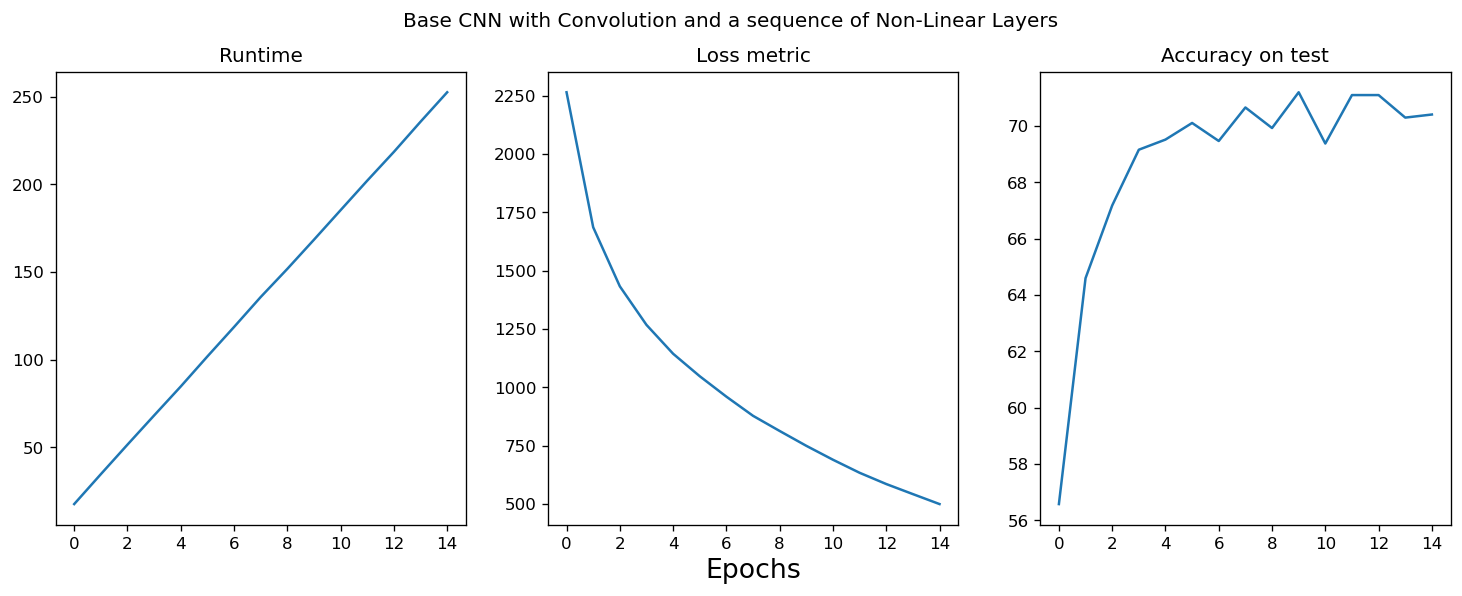

In [9]:
main_results = np.asarray(results)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5),dpi=120)
fig.suptitle('Base CNN with Convolution and a sequence of Non-Linear Layers')
ax1.plot(main_results[:,0], main_results[:,1])
ax1.set_title("Runtime")
ax2.plot(main_results[:,0], main_results[:,2])
ax2.set_title("Loss metric")
ax2.set_xlabel('Epochs', fontsize=16)
ax3.plot(main_results[:,0], main_results[:,3])
ax3.set_title("Accuracy on test")

np.savetxt("../results_CNN_base.csv", main_results, delimiter=",")